# GAN Model and Training on MNIST

In [11]:
# Import the libraries required
import torch
from torchvision import datasets, transforms, utils
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Use GPU as the device if possible
default_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(default_device)

cuda


### Hyperparameters

In [12]:
# Constants
image_resize_dimension = 64
batch_size = 128
real_label = 1
fake_label = 0

# Hyper parameters
image_channels = 1
z_dim = 100
hidden_dim_size = 64
lr = 2e-4
num_epochs = 10

In [13]:
# LOAD MNIST Data
# Mnist transform to preprocess the data
transcform_mnist_norm = transforms.Normalize((0.5,),(0.5,)).to(default_device)
transform_mnist = transforms.Compose([transforms.ToTensor(), transcform_mnist_norm, transforms.Resize(image_resize_dimension)])

# Download and load the training data
trainset_mnist = datasets.MNIST('./data/MNIST_data/', download=True, train=True, transform=transform_mnist)
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size, shuffle=True)

# Download and load the test data
testset_mnist = datasets.MNIST('./data/MNIST_data/', download=True, train=False, transform=transform_mnist)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=batch_size, shuffle=True)

In [14]:
# Print some of the MNIST dataset if flag is set
print_sample = False
if print_sample:
    real_batch = next(iter(trainloader_mnist))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(default_device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [15]:
# Proper way to initialize weights for the generator and discriminator networks based on reasearch paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [16]:
class DCGenerator(nn.Module):
    def __init__(self, z_dim=100, hidden_layer_size=64, img_channels=1):
        super(DCGenerator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(z_dim, hidden_layer_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(hidden_layer_size * 8, hidden_layer_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(hidden_layer_size * 4, hidden_layer_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(hidden_layer_size * 2, hidden_layer_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(hidden_layer_size, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        ).to(default_device)

    def forward(self, input):
        return self.main(input)
    

class DCDiscriminator(nn.Module):
    def __init__(self, hidden_layer_size=64, img_channels=1):
        super(DCDiscriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(img_channels, hidden_layer_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(hidden_layer_size, hidden_layer_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(hidden_layer_size * 2, hidden_layer_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(hidden_layer_size * 4, hidden_layer_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_layer_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(hidden_layer_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        ).to(default_device)

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [17]:
# Initialize BCELoss function
criterion = nn.BCELoss()

generator_cifar = DCGenerator(z_dim, hidden_dim_size, image_channels)
generator_cifar.apply(weights_init)
# print(generator_cifar)
discriminator_cifar = DCDiscriminator(hidden_dim_size, image_channels)
discriminator_cifar.apply(weights_init)
# print(discriminator_cifar)

# Optimizers
optimizerG_cifar = optim.Adam(generator_cifar.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerD_cifar = optim.Adam(discriminator_cifar.parameters(), lr=lr, betas=(0.5, 0.999))


DCGenerator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


## Train the Model

In [18]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
jsd_list = []
iters = 0

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(batch_size, z_dim, 1, 1, device=default_device)

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader_mnist, 0):

        # (1) Update the discriminator with real data
        discriminator_cifar.zero_grad()
        # Format batch
        real_cpu = data[0].to(default_device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=default_device)
        # Forward pass real batch through D
        output_real = discriminator_cifar(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output_real, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output_real.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, z_dim, 1, 1, device=default_device)
        # Generate fake image batch with G
        fake = generator_cifar(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator_cifar(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD_cifar.step()

        # (3) Update the generator with fake data
        generator_cifar.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output_fake = discriminator_cifar(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output_fake, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output_fake.mean().item()
        # Update G
        optimizerG_cifar.step()

        
        # JSD Calculation
        p_real = torch.mean(output_real).item()
        p_fake = torch.mean(output_fake).item()
        p_mixed = (p_real + p_fake) / 2
        jsd = 0.5 * (p_real * torch.log2(torch.tensor(p_real) / torch.tensor(p_mixed)) + 
            p_fake * torch.log2(torch.tensor(p_fake) / torch.tensor(p_mixed)))
        jsd_list.append(jsd)

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Output training stats
        if i % 250 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tJSD: %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainloader_mnist),
                     errD.item(), errG.item(), jsd, D_x, D_G_z1, D_G_z2))

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainloader_mnist)-1)):
            with torch.no_grad():
                fake = generator_cifar(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[0/10][0/469]	Loss_D: 2.2078	Loss_G: 5.3408	D(x): 0.2850	JSD: 0.6230	D(G(z)): 0.7631 / 0.0078
[0/10][250/469]	Loss_D: 0.2335	Loss_G: 3.0410	D(x): 0.2740	JSD: 0.8491	D(G(z)): 0.0395 / 0.0753
[1/10][0/469]	Loss_D: 0.2456	Loss_G: 2.7338	D(x): 0.2491	JSD: 0.8370	D(G(z)): 0.0480 / 0.0911
[1/10][250/469]	Loss_D: 0.2958	Loss_G: 2.3532	D(x): 0.2132	JSD: 0.8239	D(G(z)): 0.0769 / 0.1193
[2/10][0/469]	Loss_D: 1.0305	Loss_G: 5.2478	D(x): 0.4538	JSD: 0.9693	D(G(z)): 0.5938 / 0.0085
[2/10][250/469]	Loss_D: 0.3386	Loss_G: 3.2859	D(x): 0.3515	JSD: 0.9398	D(G(z)): 0.2210 / 0.0504
[3/10][0/469]	Loss_D: 2.7775	Loss_G: 0.3624	D(x): 0.1923	JSD: 0.1025	D(G(z)): 0.0296 / 0.7302
[3/10][250/469]	Loss_D: 1.0236	Loss_G: 2.2092	D(x): 0.0499	JSD: 0.4558	D(G(z)): 0.0114 / 0.1677
[4/10][0/469]	Loss_D: 0.2427	Loss_G: 3.9307	D(x): 0.3776	JSD: 0.9117	D(G(z)): 0.1274 / 0.0287
[4/10][250/469]	Loss_D: 0.2763	Loss_G: 3.0735	D(x): 0.2676	JSD: 0.8193	D(G(z)): 0.0543 / 0.0702
[5/10][0/469]	Loss_D: 0.4920	Loss_G: 2.4351	D(x): 

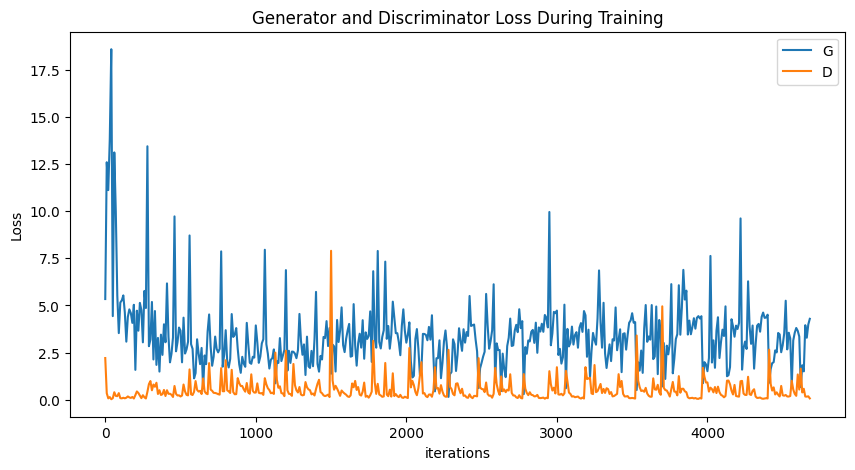

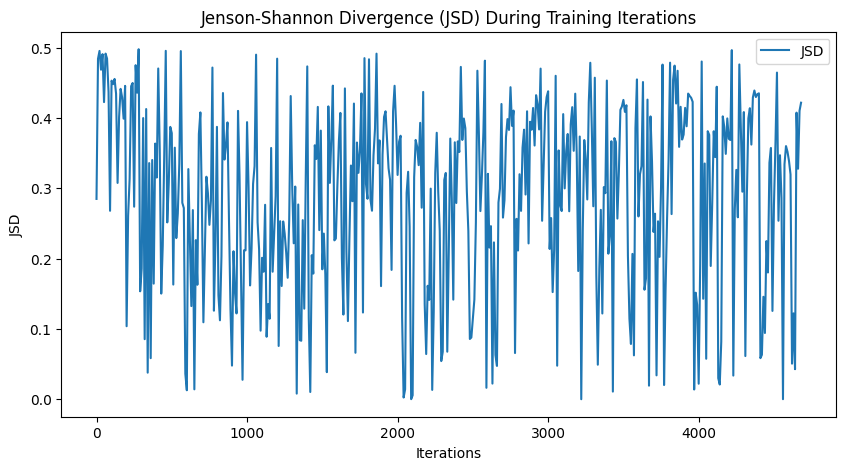

In [19]:
plot_every = 10

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(range(0, len(G_losses), plot_every), G_losses[::plot_every],label="G")
plt.plot(range(0, len(D_losses), plot_every), D_losses[::plot_every],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Jenson-Shannon Divergence (JSD) During Training Iterations")
plt.plot(range(0, len(jsd_list), plot_every), jsd_list[::plot_every],label="JSD")
plt.xlabel("Iterations")
plt.ylabel("JSD")
plt.legend()
plt.show()

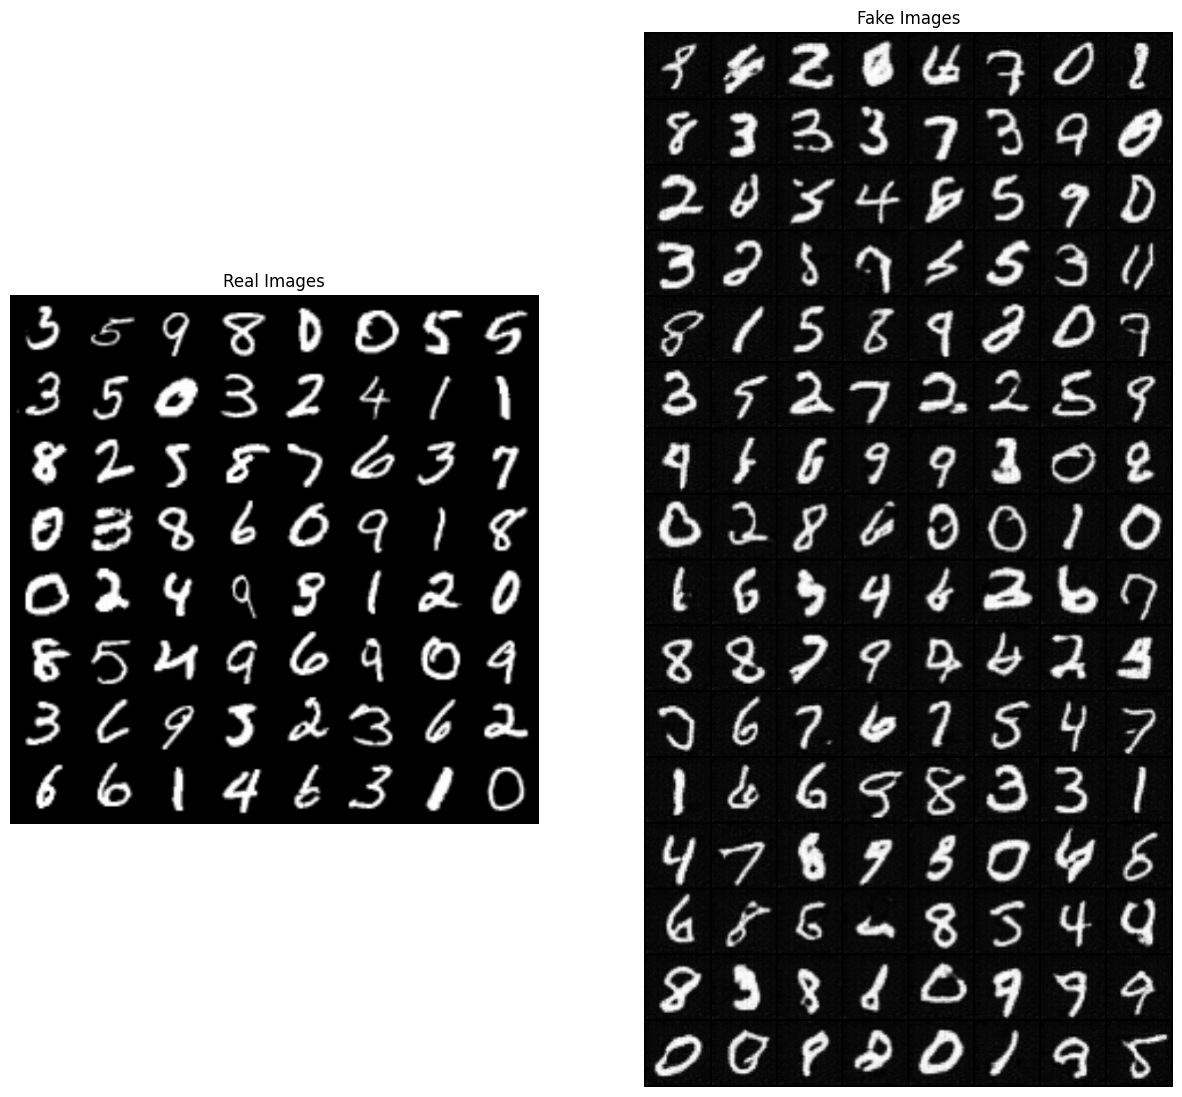

In [20]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(trainloader_mnist))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(default_device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()